In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!nvidia-smi

Sun Jul 23 17:15:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.40                 Driver Version: 536.40       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   65C    P5               9W /  65W |    941MiB /  4096MiB |     35%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref= zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-12 02:51:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.195.112, 142.250.195.144, 142.250.195.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.195.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip'

     0K .......... .......... .......... .......... ..........  0%  159K 17m14s
    50K .......... .......... .......... .......... ..........  0%  197K 15m34s
   100K .......... .......... .......... .......... ..........  0%  459K 12m22s
   150K .......... .......... .......... .......... ..........  0%  452K 10m47s
   200K .......... .......... .......... .......... ..........  0%  687K 9m26s
   250K .......... .......... .......... .......... ..........  0%  951K 8m20s
   300K .......... .......... .......... .......... .........

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE =(224,224)
EPOCHS =5
BATCH_SIZE=32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,target_size=IMAGE_SHAPE,batch_size=BATCH_SIZE,class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_dir,batch_size=BATCH_SIZE,class_mode="categorical",target_size=IMAGE_SHAPE)

Training Images:
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up call backs (things to run whilst our model trains)
Callbacks are extra functionality you can add to your models to performed during or after training some of most call backs are
* tracking experiments with tensorfboard call back
* mode checkpoint with model checkpoint call back
* stopping a model from trainnig before it trains too long and overfits using early stop callback

In [19]:
# creating a tensorboard call back 
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to : {log_dir}")
    return tensorboard_callback

In [1]:
import numpy as np
print(np.__version__)
#print cuda version
!nvcc --version

1.23.0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [9]:
import tensorflow as tf

import tensorflow_hub as hub
from tensorflow.keras import layers


In [10]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2" 

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers



In [12]:
def create_model(model_url,num_classes=10):
    feature_extractor_layer= hub.KerasLayer(model_url,trainable=False,name="feature_extraction_layer",input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes,activation="softmax",name="output_layer")
    ])     
    return model

## Creating and Testing a ResNet Tensorflow Hub Feature Extraction model

In [13]:
resent_model = create_model(resnet_url,num_classes=train_data_10_percent.num_classes)


In [14]:
resent_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
resent_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [20]:
resent_history= resent_model.fit(train_data_10_percent,epochs=EPOCHS,steps_per_epoch=len(train_data_10_percent),validation_data=test_data,callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="resent50v2")])

Saving Tensorboard log files to : tensorflow_hub/resent50v2/20230724-204013
Epoch 1/5
24/24 [==============================] - 75s 2s/step - loss: 1.9049 - accuracy: 0.3760 - val_loss: 1.1850 - val_accuracy: 0.6056
Epoch 2/5
24/24 [==============================] - 15s 649ms/step - loss: 0.9025 - accuracy: 0.7333 - val_loss: 0.8387 - val_accuracy: 0.7364
Epoch 3/5
24/24 [==============================] - 15s 624ms/step - loss: 0.6150 - accuracy: 0.8307 - val_loss: 0.7717 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 15s 626ms/step - loss: 0.4952 - accuracy: 0.8600 - val_loss: 0.7223 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 17s 721ms/step - loss: 0.3851 - accuracy: 0.9053 - val_loss: 0.6741 - val_accuracy: 0.7788


In [21]:
# plot validation and training curves seperately
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss =  history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    

    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.figure()
    plt.plot(epochs,accuracy,label="training_accuracy")
    plt.plot(epochs,val_accuracy,label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    


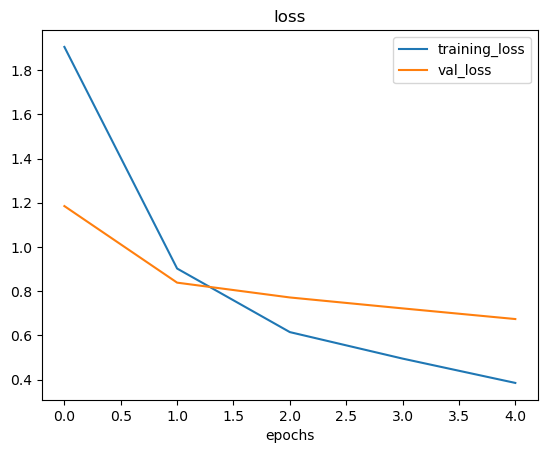

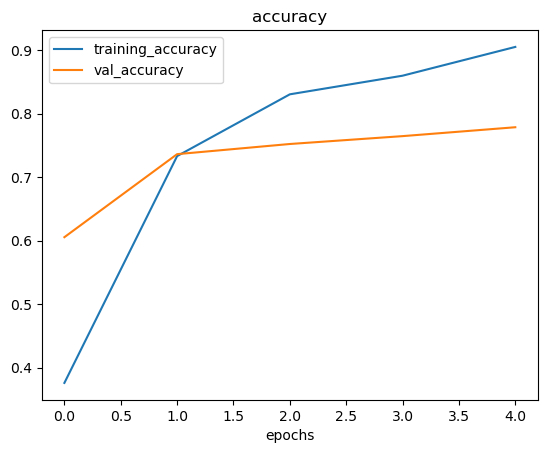

In [22]:
plot_loss_curves(resent_history)


## Creating and Testing a Efficient Net Tensorflow Hub Feature Extraction model

In [23]:
efficient_net_model = create_model(efficientnet_url, num_classes=10)
efficient_net_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
efficientnet_history = efficient_net_model.fit(train_data_10_percent,epochs=EPOCHS,steps_per_epoch=len(train_data_10_percent),validation_data=test_data,callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnetb0")])

Saving Tensorboard log files to : tensorflow_hub/efficientnetb0/20230724-205120
Epoch 1/5
24/24 [==============================] - 30s 770ms/step - loss: 1.8714 - accuracy: 0.4573 - val_loss: 1.2944 - val_accuracy: 0.7412
Epoch 2/5
24/24 [==============================] - 13s 575ms/step - loss: 1.0510 - accuracy: 0.7800 - val_loss: 0.8606 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 14s 583ms/step - loss: 0.7510 - accuracy: 0.8293 - val_loss: 0.6915 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 14s 583ms/step - loss: 0.6046 - accuracy: 0.8613 - val_loss: 0.6067 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 14s 583ms/step - loss: 0.5124 - accuracy: 0.8960 - val_loss: 0.5539 - val_accuracy: 0.8632


In [24]:
efficient_net_model.evaluate(test_data)

79/79 [==============================] - 11s 142ms/step - loss: 0.5539 - accuracy: 0.8632


[0.5539426207542419, 0.8632000088691711]

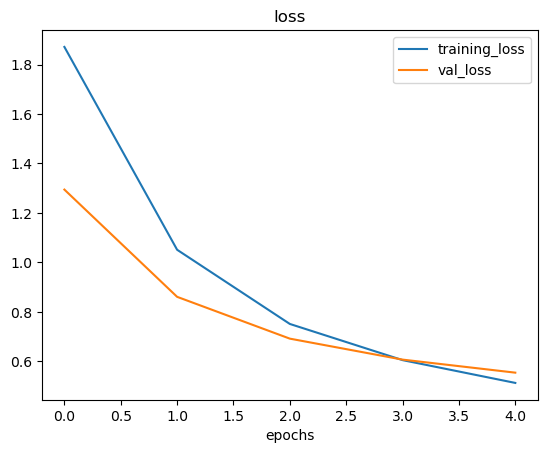

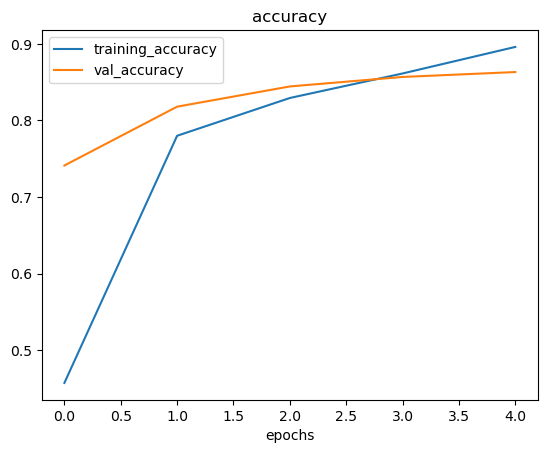

In [25]:
plot_loss_curves(efficientnet_history)